In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras

import tensorflow as tf
from tensorflow import data as tf_data


from preprocess_common import *

2025-02-26 20:26:05.605129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
PATH="archive/"

#Hyperparameters
AUTO = tf_data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 10
VALIDATION_SIZE = 15000

In [3]:
class_names=['Human', 'AI']

train_df = pd.read_csv('./archive/train.csv', index_col=0)
test_df = pd.read_csv('./archive/test.csv')

train_paths = train_df["file_name"].array
train_labels = train_df["label"].array
test_paths = test_df["id"].array

In [4]:
#Split into training and validation
training_validation_paths = train_paths[:VALIDATION_SIZE]
training_validation_labels = keras.ops.one_hot(train_labels[:VALIDATION_SIZE],2)
training_paths = train_paths[VALIDATION_SIZE:]
training_labels = keras.ops.one_hot(train_labels[VALIDATION_SIZE:],2)

# Shuffles and batches the datasets
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((training_paths, training_labels))
    .shuffle(1024)
    .map(lambda filename, label: resize_flip_scale_image(PATH+filename, label), num_parallel_calls=AUTO)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((training_paths, training_labels))
    .shuffle(1024)
    .map(lambda filename, label: resize_flip_scale_image(PATH+filename, label), num_parallel_calls=AUTO)
)

# Combine the two datasets
train_ds = tf_data.Dataset.zip((train_ds_one, train_ds_two))


# Test dataset is unlabelled so 
# test_ds = (
#     tf_data.Dataset.from_tensor_slices((test_paths, test_labels))
#     .map(lambda filename, label: resize_flip_scale_image(PATH+filename, label), num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
# )

val_ds = (
    tf_data.Dataset.from_tensor_slices((training_validation_paths, training_validation_labels))
    .map(lambda filename, label: resize_flip_scale_image(PATH+filename, label), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2025-02-26 20:26:06.804906: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-26 20:26:08.068812: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-26 20:26:08.068859: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-26 20:26:08.070170: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-26 20:26:08.070290: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

2025-02-26 20:26:09.430762: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node mod/_6}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-02-26 20:26:09.430809: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node mod/_6}}]]
	 [[ReadVariableOp_1/_10]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-02-26 20:26:09.430820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5430506929888268939
2025-02-26 20:26:09.430825: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17644155772074203911
2025-02-26 20:26:09.430832: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16498605684184280117
2025-02-26 20:26:09.430837: I tensorflow/core/framework/local_re

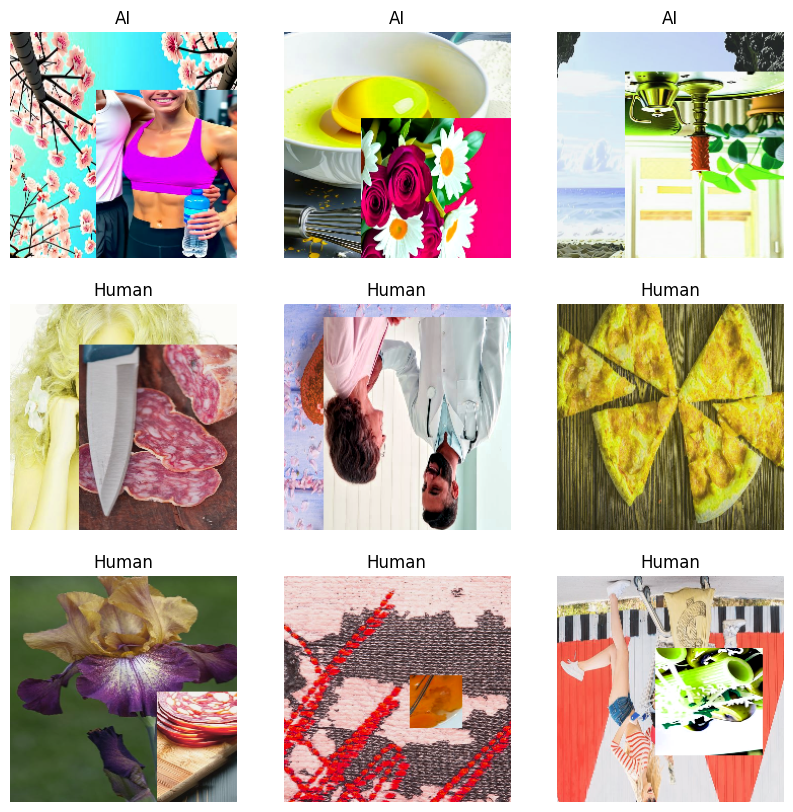

In [5]:
mixer = Mix(img_size=224)
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(mixer.cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")
